분석이 성공적으로 종료되었습니다.

Estimated β, σ, γ, ε: 3.18013015e-01 3.88504094e-02 1.00000000e-04 1.00000000e-04
Estimated Exposed: 1
Total Square Error: 2593046.673600926
Annealing Optimizer Message: ['Maximum number of iteration reached']
SHGO Optimizer Message: Optimization terminated successfully.

분석이 성공적으로 종료되었습니다.

Estimated β, σ, γ, ε: 2.31953639e-01 1.00000000e+00 5.18821258e-04 9.34533616e-04
Estimated Exposed: 514
Total Square Error: 2019941.1848848867
Annealing Optimizer Message: ['Maximum number of iteration reached']
SHGO Optimizer Message: Optimization terminated successfully.

분석이 성공적으로 종료되었습니다.

Estimated β, σ, γ, ε: 0.18422271 1.         0.04854828 0.0040358 
Estimated Exposed: 585
Total Square Error: 27860659319.168064
Annealing Optimizer Message: ['Maximum number of iteration reached']
SHGO Optimizer Message: Optimization terminated successfully.

Estimated R0 of Korea 1.22~ : 1590.0650772293104
Estimated R0 of Korea 2.20~ : 159.5987619952195
Estimated R0 of Hubei, China: 3.50

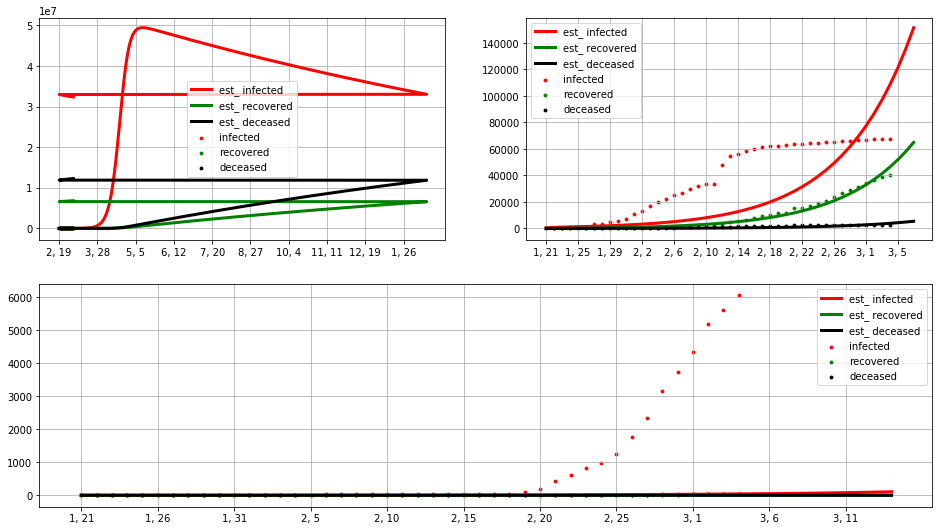

In [3]:
from datetime import datetime
import re
import sys
import time
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import dual_annealing, shgo
from scipy.signal import savgol_filter
 
 
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["font.family"] = 'NanumGothic'
 
now = int((time.time() - 1579618800) / 86400)
parameter = {}
repo = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/"
 
 
def load(csv, line=np.hstack((range(1, 32), 33, 34))):
    csv = csv.splitlines()
    return list(map(lambda l: re.split('[,\n]+', csv[l]), line))
 
 
def read(cov_data, population, start, stop, smooth=False):
    smoothing = lambda x: savgol_filter(x, 5, 3) if smooth else x
    return list(map(lambda x: {'state': cov_data[x, 0, 0],
                               'y': smoothing(cov_data[x, :, 4:].astype(np.float)),
                               'p': int(population[x])}, range(start, stop)))
 
 
def model(args, init_y, t):
    def DIFF_SEIR(y, _, beta, sigma, gamma, epsilon):
        dSdt = - beta * y[0] * y[2] / init_y.sum()
        dEdt = (beta * y[0] * y[2] / init_y.sum()) - (sigma * y[1])
        dIdt = (sigma * y[1]) - ((gamma + epsilon) * y[2])
        dRdt = gamma * y[2]
        dDdt = epsilon * y[2]
        return dSdt, dEdt, dIdt, dRdt, dDdt
 
    return odeint(DIFF_SEIR, init_y, np.arange(t), tuple(args)).T
 
 
def model_loss(args, init_y, y):
    est_y = model(args, init_y, y.shape[1])
    err = ((y - est_y[2:]) ** 2).sum()
    return np.sqrt(err)
 
 
def model_fit(init_y, y):
    return dual_annealing(model_loss, ((0, 10), (0, 1), (1e-4, 1), (1e-4, 1)), args=(init_y, y), maxiter=20, seed=0)
 
 
def e_loss(e, data, parameter_name):
    global parameter
    y, population = data['y'], data['p']
    init_y = np.hstack((population - e - y[:, 0].sum(), e, y[:, 0]))
    parameter[parameter_name] = model_fit(init_y, y)
    est_y = model(parameter[parameter_name].x, init_y, y.shape[1])[2:]
    return ((est_y - y) ** 2).sum()
 
 
def fit(data, parameter_name):
    return shgo(e_loss, ((1, data['p'] / 100000),), args=(data, parameter_name))
 
 
def model_result(optimized_object_e, optimized_object_parameter):
    if optimized_object_e.success is True and optimized_object_parameter.success is True:
        sys.stdout.write('\r분석이 성공적으로 종료되었습니다.\n\n')
    elif optimized_object_e.success is True and optimized_object_parameter.success is False:
        sys.stdout.write('\rβ, σ, γ, ε 값의 최적화에 실패하였습니다.\n\n')
    elif optimized_object_e.success is False and optimized_object_parameter.success is True:
        sys.stdout.write('\rExposed 값의 최적화에 실패하였습니다.\n\n')
    else:
        sys.stdout.write('\r모든 값의 최적화에 실패하였습니다.\n\n')
 
    sys.stdout.write(f'Estimated β, σ, γ, ε: {str(optimized_object_parameter.x)[1:-1]}\n'
                     f'Estimated Exposed: {str(int(optimized_object_e.x))}\n'
                     f'Total Square Error: {optimized_object_e.fun}\n'
                     f'Annealing Optimizer Message: {optimized_object_parameter.message}\n'
                     f'SHGO Optimizer Message: {optimized_object_e.message}\n\n')
 
 
def plot(args, e, data, start, stop, draw_group, draw_pose):
    plt.subplot(draw_pose)
    y = data['y']
    c = ['blue', 'yellow', 'red', 'green', 'black']
    g = ['susceptible', 'exposed', 'infected', 'recovered', 'deceased']
    est = model(args, np.hstack((data['p'] - e - data['y'][:, 0].sum(), e, data['y'][:, 0])), stop - start)
    date = [str(datetime.fromtimestamp(1579618800 + 86400 * n).timetuple()[1:3])[1:-1] for n in range(start, stop)]
    for i in range(draw_group.start, draw_group.stop):
        if i > 1:
            plt.scatter(date[:min(stop, y.shape[1])], y[i - 2, :min(stop, y.shape[1])], color=c[i], label=g[i], s=8)
        plt.plot(date, est[i], color=c[i], label='est_ ' + g[i], linewidth=3)
    if len(date) > 10:
        plt.xticks(np.arange(0, stop - start, 0.1 * (stop - start - (stop - start) % 10)))
    plt.legend()
    plt.grid()
 
 
def main():
    CONFIRMED_RAW = requests.get(repo + "csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
    RECOVERED_RAW = requests.get(repo + "csse_covid_19_time_series/time_series_19-covid-Recovered.csv")
    DEATHS_RAW = requests.get(repo + "csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
 
    if not all(199 < i < 300 for i in (CONFIRMED_RAW.status_code, RECOVERED_RAW.status_code, DEATHS_RAW.status_code)):
        raise ConnectionError("서버의 응답 중 하나 이상의 상태 코드가 올바르지 않아 데이터를 불러오지 못했습니다.")
 
    data = np.asarray([load(CONFIRMED_RAW.text),
                       load(RECOVERED_RAW.text),
                       load(DEATHS_RAW.text)], dtype='<U14').swapaxes(0, 1)
 
    population = [62000000, 21540000, 30480000, 38560000, 25580000, 113460000, 48380000, 34750000, 9258000, 74700000,
                  38310000, 94000000, 58500000, 67370000, 24710000, 80400000, 45200000, 27460000, 43900000, 6301000,
                  5627000, 37330000, 100472400, 24240000, 36500000, 81100000, 15621200, 3180000, 21810000, 45970000,
                  57370000, 126800000, 51470000]
 
    data = {'Korea': read(data, population, 32, 33),
            'Japan': read(data, population, 31, 32),
            'China': read(data, population, 0, 31)}
 
    data['Korea'].append(data['Korea'][0].copy())
    data['Korea'][1]['y'] = data['Korea'][1]['y'][:, 29:]
    plt.figure(num='분석 보고')
 
    sys.stdout.write('데이터 불러오기 성공, 첫 번째 분석을 시작했습니다.')
 
    e_0_all = fit(data['Korea'][0], '0')
    model_result(e_0_all, parameter['0'])
    plot(parameter['0'].x, e_0_all.x, data['Korea'][0], 0, now + 10, slice(2, 5), 212)
 
    sys.stdout.write('두 번째 분석을 시작했습니다.')
 
    e_0_sin = fit(data['Korea'][1], '1')
    model_result(e_0_sin, parameter['1'])
    plot(parameter['1'].x, e_0_sin.x, data['Korea'][1], 29, now + 365, slice(2, 5), 221)
 
    sys.stdout.write('세 번째 분석을 시작했습니다.')
 
    e_0_cha = fit(data['China'][12], '2')
    model_result(e_0_cha, parameter['2'])
    plot(parameter['2'].x, e_0_cha.x, data['China'][12], 0, now + 3, slice(2, 5), 222)
 
    sys.stdout.write(f"Estimated R0 of Korea 1.22~ : {parameter['0'].x[0] / parameter['0'].x[2:4].sum()}\n"
                     f"Estimated R0 of Korea 2.20~ : {parameter['1'].x[0] / parameter['1'].x[2:4].sum()}\n"
                     f"Estimated R0 of Hubei, China: {parameter['2'].x[0] / parameter['2'].x[2:4].sum()}\n")
 
    plt.show()
 
 
if __name__ == "__main__":
    main()